# The e2e Model Lifecycle on SAS Viya Platform

In this notebook, 

1. Build and train the model.
2. Create an API of the model. (Here we have put it in a flask API).
3. Create the requirements file containing all the required libraries.
4. Create the docker file with necessary environment setup and start-up operations.
5. Build the docker image.

I train XGboost model for testing Docker Private ML environment

## Libraries

In [46]:
# Mongo Library

import pymongo

# ML libraries 

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import statsmodels.api as smodel
from xgboost import XGBClassifier 

# Tool libraries

# import json
import os
# import requests as req
# import random
# import pickle
# import zipfile
# import urllib
# import base64
# import time
# import sys

# import sasctl

## Data Engineering

### Load Data from Mongo

In [2]:
#Connect to mongodb container

conn = pymongo.MongoClient('mongo', 27017)

In [3]:
conn

MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True)

In [4]:
db = conn.training
collection = db.churn_data

In [5]:
df = pd.DataFrame(list(collection.find()))
df.drop('_id', axis=1, inplace=True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.3667,1,9,
1,1,1300,70053,68400,HomeImp,Other,7,0,2,121.833,0,14,
2,1,1500,13500,16700,HomeImp,Other,4,0,0,149.467,1,10,
3,1,1500,,,,,,,,,,,
4,0,1700,97800,112000,HomeImp,Office,3,0,0,93.3333,0,14,


### Declare data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77480 entries, 0 to 77479
Data columns (total 13 columns):
BAD        77480 non-null int64
LOAN       77480 non-null int64
MORTDUE    77480 non-null object
VALUE      77480 non-null object
REASON     77480 non-null object
JOB        77480 non-null object
YOJ        77480 non-null object
DEROG      77480 non-null object
DELINQ     77480 non-null object
CLAGE      77480 non-null object
NINQ       77480 non-null object
CLNO       77480 non-null object
DEBTINC    77480 non-null object
dtypes: int64(2), object(11)
memory usage: 7.7+ MB


In [7]:
cols = df[df.columns.difference(['BAD','LOAN','REASON','JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD']=df['BAD'].astype('category')

In [8]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333336,0.0,14.0,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77480 entries, 0 to 77479
Data columns (total 13 columns):
BAD        77480 non-null category
LOAN       77480 non-null int64
MORTDUE    70746 non-null float32
VALUE      76024 non-null float32
REASON     77480 non-null object
JOB        77480 non-null object
YOJ        70785 non-null float32
DEROG      68276 non-null float32
DELINQ     69940 non-null float32
CLAGE      73476 non-null float32
NINQ       70850 non-null float32
CLNO       74594 non-null float32
DEBTINC    61009 non-null float32
dtypes: category(1), float32(9), int64(1), object(2)
memory usage: 4.5+ MB


### Declare variables 

In [14]:
#target var
target = df.select_dtypes('category').columns

#categorical (nominal and ordinal) variables
class_inputs = list(df.select_dtypes('object').columns)

#input interval variables
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

inputs= class_inputs + numerical_inputs

print(target)
print(class_inputs)
print(numerical_inputs)
print(inputs)

Index(['BAD'], dtype='object')
['REASON', 'JOB']
['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
['REASON', 'JOB', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [15]:
df[inputs]

,REASON,JOB,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,HomeImp,Other,1100,25860.0,39025.0,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,HomeImp,Other,1300,70053.0,68400.0,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,HomeImp,Other,1500,13500.0,16700.0,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,,,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HomeImp,Office,1700,97800.0,112000.0,3.0,0.0,0.0,93.333336,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
77475,DebtCon,Other,89000,54576.0,92937.0,16.0,0.0,0.0,208.692062,0.0,15.0,35.859970
77476,DebtCon,Other,89200,54045.0,92924.0,15.0,0.0,0.0,212.279694,0.0,15.0,35.556591
77477,DebtCon,Other,87000,48980.0,89764.0,14.0,0.0,0.0,209.043121,0.0,16.0,36.088036
77478,DebtCon,Other,89900,48811.0,88934.0,15.0,0.0,0.0,219.600998,0.0,16.0,34.571518


### Impute missing

In [16]:
categorical_imputer = SimpleImputer(missing_values = '', strategy = 'most_frequent')
numerical_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# Impute categorical variables

categorical_imputer.fit(df[class_inputs])
categorical_imputed = categorical_imputer.transform(df[class_inputs])
df_categorical_imputed = pd.DataFrame(data=categorical_imputed, columns=class_inputs)
df_categorical_imputed.info()

print('-'*50)

#Impute numerical variables

numerical_imputer.fit(df[numerical_inputs])
numerical_imputed = numerical_imputer.transform(df[numerical_inputs])
df_numerical_imputed = pd.DataFrame(data=numerical_imputed, columns=numerical_inputs)
df_numerical_imputed.info()
df_numerical_imputed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77480 entries, 0 to 77479
Data columns (total 2 columns):
REASON    77480 non-null object
JOB       77480 non-null object
dtypes: object(2)
memory usage: 1.2+ MB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77480 entries, 0 to 77479
Data columns (total 10 columns):
LOAN       77480 non-null float64
MORTDUE    77480 non-null float64
VALUE      77480 non-null float64
YOJ        77480 non-null float64
DEROG      77480 non-null float64
DELINQ     77480 non-null float64
CLAGE      77480 non-null float64
NINQ       77480 non-null float64
CLNO       77480 non-null float64
DEBTINC    77480 non-null float64
dtypes: float64(10)
memory usage: 5.9 MB


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915
1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915
2,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915
3,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915
...,...,...,...,...,...,...,...,...,...,...
77475,89000.0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970
77476,89200.0,54045.000000,92924.000000,15.000000,0.00000,0.000000,212.279694,0.000000,15.000000,35.556591
77477,87000.0,48980.000000,89764.000000,14.000000,0.00000,0.000000,209.043121,0.000000,16.000000,36.088036
77478,89900.0,48811.000000,88934.000000,15.000000,0.00000,0.000000,219.600998,0.000000,16.000000,34.571518


### One-Hot encoding for categorical variables

In [17]:
encoder = OneHotEncoder()
encoder.fit(categorical_imputed)
categorical_encoded = encoder.transform(categorical_imputed)

categories = list(np.hstack(encoder.categories_, ))
categories

# print(categorical_encoded.toarray())
df_categorical_encoded = pd.DataFrame(data=categorical_encoded.toarray(), columns=categories)
df_categorical_encoded.info()
df_categorical_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77480 entries, 0 to 77479
Data columns (total 8 columns):
DebtCon    77480 non-null float64
HomeImp    77480 non-null float64
Mgr        77480 non-null float64
Office     77480 non-null float64
Other      77480 non-null float64
ProfExe    77480 non-null float64
Sales      77480 non-null float64
Self       77480 non-null float64
dtypes: float64(8)
memory usage: 4.7 MB


,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
77475,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
77476,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
77477,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
77478,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### ABT

In [18]:
abt = pd.concat([df[target], df_numerical_imputed, df_categorical_encoded], axis=1)
abt


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,1,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77475,0,89000.0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
77476,0,89200.0,54045.000000,92924.000000,15.000000,0.00000,0.000000,212.279694,0.000000,15.000000,35.556591,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
77477,0,87000.0,48980.000000,89764.000000,14.000000,0.00000,0.000000,209.043121,0.000000,16.000000,36.088036,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
77478,0,89900.0,48811.000000,88934.000000,15.000000,0.00000,0.000000,219.600998,0.000000,16.000000,34.571518,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Model Development

In [30]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(abt[abt.columns.difference(target)], 
                                                                    abt[target], 
                                                                    test_size=0.33, random_state=27513)

In [27]:
%%time

model = XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=10,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=10,
          eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.13120	validation_0-logloss:0.63259	validation_1-error:0.12969	validation_1-logloss:0.63237
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.13022	validation_0-logloss:0.58261	validation_1-error:0.12914	validation_1-logloss:0.58279
[2]	validation_0-error:0.13001	validation_0-logloss:0.54133	validation_1-error:0.12906	validation_1-logloss:0.54150
[3]	validation_0-error:0.11604	validation_0-logloss:0.51051	validation_1-error:0.11827	validation_1-logloss:0.51070
[4]	validation_0-error:0.12080	validation_0-logloss:0.48288	validation_1-error:0.12081	validation_1-logloss:0.48326
[5]	validation_0-error:0.11974	validation_0-logloss:0.45728	validation_1-error:0.12042	validation_1-logloss:0.45768
[6]	validation_0-error:0.11448	validation_0-logloss:0.43568	validation_1-error:0.11533	validation_1-logloss:0.43604
[7]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='auto', validate_parameters=False, verbosity=1)

## Model Assessment

In [23]:
dt_misclassification = 1 - metrics.accuracy_score(y_test, model.predict(X_test))
print('Misclassification Rates\n', 'XGBoost :', dt_misclassification)

Misclassification Rates
 XGBoost : 0.11482654777269352


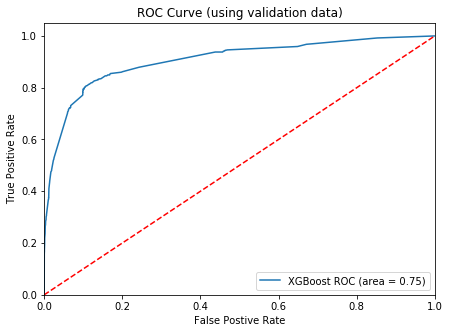

In [24]:
models = [{'label': 'XGBoost','model': model}]

plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

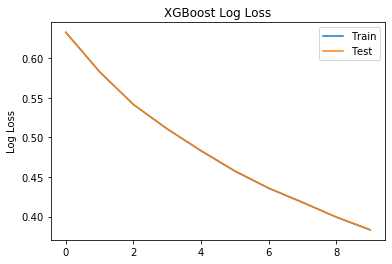

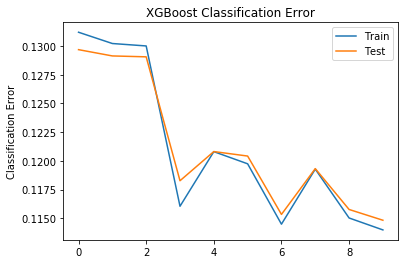

In [25]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


## Machine Learning Engineering

### Create ML pipeline

In [28]:
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

xgb_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=10,
                        learning_rate = 0.1))

])



## Test fit and predict

In [40]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[df.columns.difference(target)], 
                                                                    df[target], 
                                                                    test_size=0.33, random_state=27513)

In [41]:
xgb_pipeline.fit(X_train, y_train)
y_predict=xgb_pipeline.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
xgb_pipeline.score(X_test, y_test)

0.8926434354100669

# Model Deployment

For Model Deployment purpose, we need some files:

    0. requirement.txt    
    1. score.py
    2. model.pickle
    3. dmcas_fitstat.json
    4. inputVar.json
    5. outputVar.json
    6. fileMetadata.json
    7. ModelProperties.json


In [47]:
! mkdir xgboost

mkdir: cannot create directory ‘xgboost’: File exists
/home/jovyan/work


## 1. requirement.txt

In [48]:
! pip freeze > ./xgboost/requirement.txt

## 2. Score.py 

## 3. model.pkl

In [50]:
from sklearn.externals import joblib
joblib.dump(xgb_pipeline, './xgboost/xgb_pipeline.pkl')

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['./xgboost/xgb_pipeline.pkl']

## 4. inputVar.py

In [9]:
from utils import modelmanager_service

In [10]:
modelmanager_utils.inputjson()

TypeError: inputjson() missing 3 required positional arguments: 'traindf', 'target', and 'outdir'